In [271]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix




# a)

In [246]:
california_data = pickle.load(open('california-housing-dataset.pkl', 'rb'))
x_train, y_train = california_data['x_train'], california_data['y_train']
x_test, y_test = california_data['x_test'], california_data['y_test']


In [247]:
print("Training set dimensions:", x_train.shape, y_train.shape)


Training set dimensions: (15480, 8) (15480,)


In [248]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Sample x_train:", x_train[0])
print("Sample y_train:", y_train[0])


Shape of x_train: (15480, 8)
Shape of y_train: (15480,)
Sample x_train: [ 2.66180000e+00  1.00000000e+01  6.20408163e+00  1.25510204e+00
  1.40300000e+03  2.04518950e+00  3.41000000e+01 -1.16320000e+02]
Sample y_train: 0.81


In [249]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


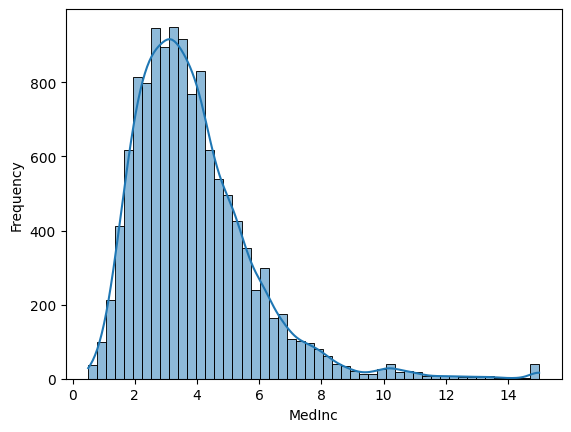

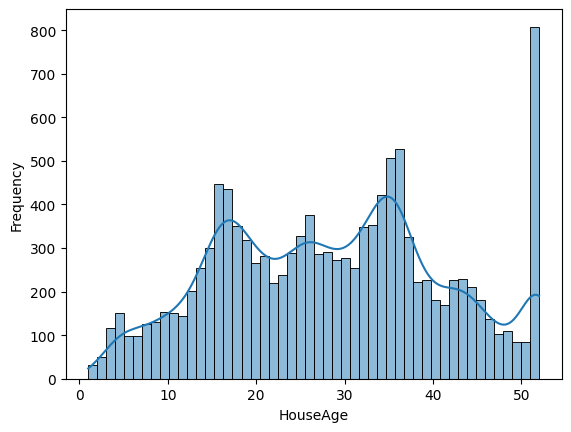

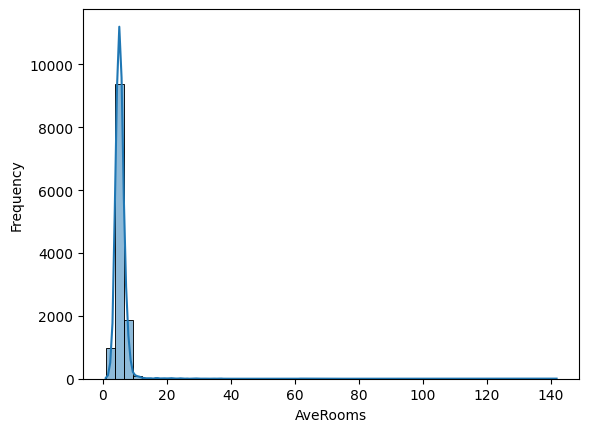

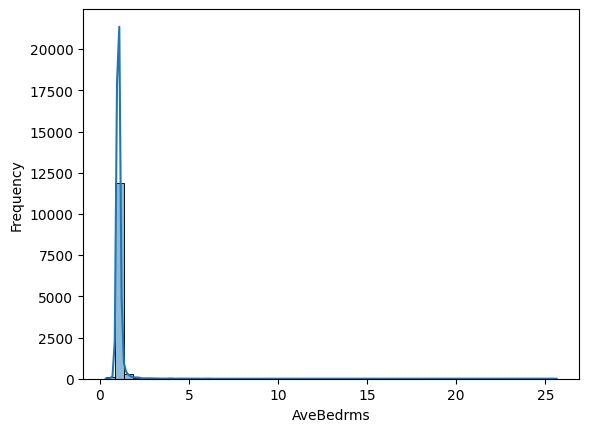

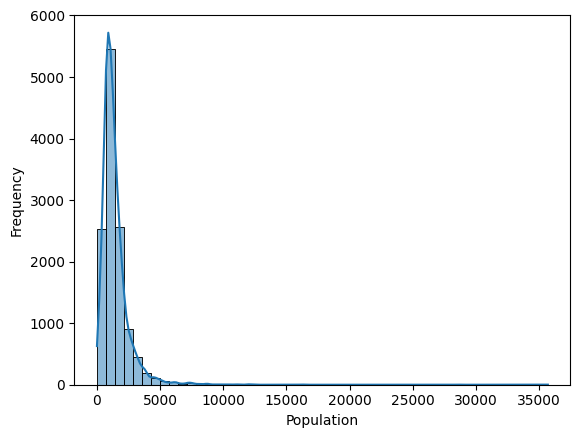

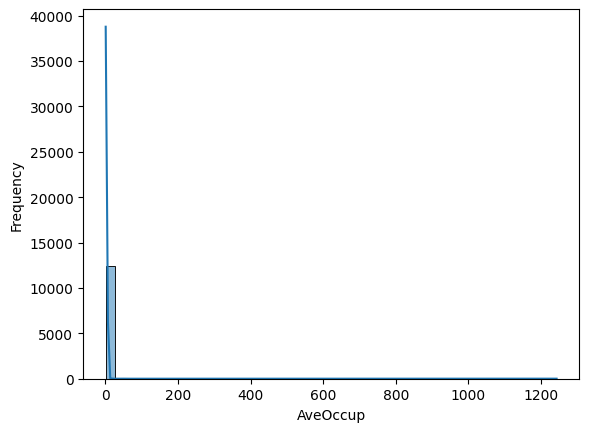

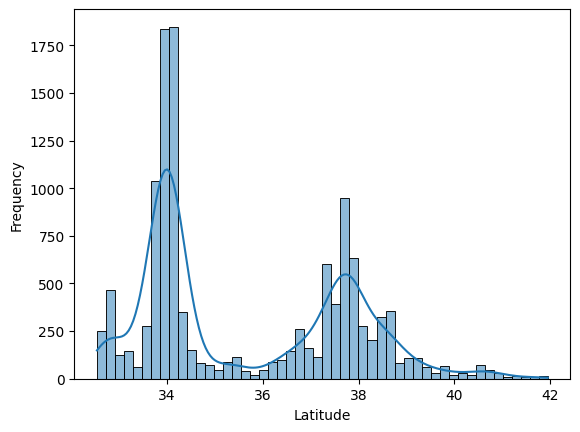

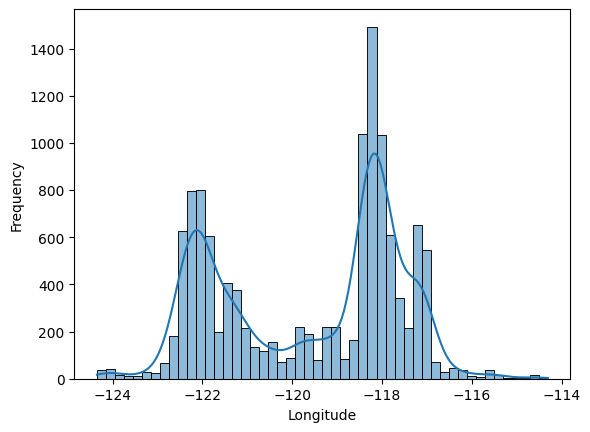

In [250]:
feature_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

for i in range(x_train.shape[1]):
    sns.histplot(x_train[:, i], bins=50, kde=True)
    plt.xlabel(feature_names[i])  # Use the feature name as x-axis label
    plt.ylabel('Frequency')
    plt.show()



In [251]:
scaler = StandardScaler()

x_train_normalized = scaler.fit_transform(x_train)
x_val_normalized = scaler.transform(x_val)

print("Sample normalized x_train:", x_train_normalized[0])
print("Sample normalized x_val:", x_val_normalized[0])

Sample normalized x_train: [-0.24641734 -1.63084141  0.10467077 -0.06579177  0.68050224  0.03377491
 -0.59199349  1.11993362]
Sample normalized x_val: [ 0.12303892  0.66191525 -0.06989343 -0.09129668 -0.12244089  0.02285162
 -0.74176514  0.81603931]


# b)

In [252]:
model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_shape=(x_train_normalized.shape[1],)),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1)  # Output layer for regression task
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

batch_size = 32
epochs = 10

history = model.fit(
    x_train_normalized, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val_normalized, y_val),
    verbose=2
)


Epoch 1/10
387/387 - 2s - loss: 0.8978 - mae: 0.6409 - val_loss: 0.4363 - val_mae: 0.4641 - 2s/epoch - 5ms/step
Epoch 2/10
387/387 - 1s - loss: 0.4316 - mae: 0.4631 - val_loss: 0.3846 - val_mae: 0.4548 - 659ms/epoch - 2ms/step
Epoch 3/10
387/387 - 1s - loss: 0.3958 - mae: 0.4449 - val_loss: 0.3576 - val_mae: 0.4230 - 663ms/epoch - 2ms/step
Epoch 4/10
387/387 - 1s - loss: 0.3791 - mae: 0.4329 - val_loss: 0.3388 - val_mae: 0.4192 - 659ms/epoch - 2ms/step
Epoch 5/10
387/387 - 1s - loss: 0.3619 - mae: 0.4233 - val_loss: 0.3280 - val_mae: 0.4040 - 655ms/epoch - 2ms/step
Epoch 6/10
387/387 - 1s - loss: 0.3511 - mae: 0.4157 - val_loss: 0.3180 - val_mae: 0.4096 - 656ms/epoch - 2ms/step
Epoch 7/10
387/387 - 1s - loss: 0.3399 - mae: 0.4088 - val_loss: 0.3127 - val_mae: 0.3941 - 740ms/epoch - 2ms/step
Epoch 8/10
387/387 - 1s - loss: 0.3385 - mae: 0.4029 - val_loss: 0.3098 - val_mae: 0.3970 - 746ms/epoch - 2ms/step
Epoch 9/10
387/387 - 1s - loss: 0.3245 - mae: 0.3964 - val_loss: 0.3008 - val_mae: 

In [253]:
train_loss, train_mae = model.evaluate(x_train_normalized, y_train, verbose=0)
val_loss, val_mae = model.evaluate(x_val_normalized, y_val, verbose=0)

print(f"Training Set - Loss: {train_loss}, MAE: {train_mae}")
print(f"Validation Set - Loss: {val_loss}, MAE: {val_mae}")


Training Set - Loss: 0.31701168417930603, MAE: 0.3965091407299042
Validation Set - Loss: 0.29972389340400696, MAE: 0.39501863718032837


In [254]:
layers = [
    [64, 32],
    [128, 64, 32],
    [256, 128, 64, 32],  # Adding more layers
    [64, 64, 64],        # More units in each layer
    [128, 128, 64, 32],   # Balanced number of units
    [64, 128, 256, 128, 64],  # Increasing and then decreasing units
]

results = []

for arch in layers:
    model = keras.Sequential([
        keras.layers.Dense(units=units, activation='relu', input_shape=(x_train_normalized.shape[1],))
        for units in arch
    ])
    model.add(keras.layers.Dense(units=1))  # Output layer for regression task

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    history = model.fit(
        x_train_normalized, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val_normalized, y_val),
        verbose=0
    )

    train_loss, _ = model.evaluate(x_train_normalized, y_train, verbose=0)
    val_loss, _ = model.evaluate(x_val_normalized, y_val, verbose=0)

    results.append({'layers': arch, 'train_loss': train_loss, 'val_loss': val_loss})

for result in results:
    print(f"layers: {result['layers']}, Train Loss: {result['train_loss']}, Val Loss: {result['val_loss']}")


layers: [64, 32], Train Loss: 0.3102494776248932, Val Loss: 0.2993045747280121
layers: [128, 64, 32], Train Loss: 0.2962610423564911, Val Loss: 0.285380482673645
layers: [256, 128, 64, 32], Train Loss: 0.28587186336517334, Val Loss: 0.29208409786224365
layers: [64, 64, 64], Train Loss: 0.2983257472515106, Val Loss: 0.272836834192276
layers: [128, 128, 64, 32], Train Loss: 0.3011941611766815, Val Loss: 0.29400303959846497
layers: [64, 128, 256, 128, 64], Train Loss: 0.29368045926094055, Val Loss: 0.29349443316459656


In [255]:
results_df = pd.DataFrame(results)
results_df


,layers,train_loss,val_loss
0,"[64, 32]",0.310249,0.299305
1,"[128, 64, 32]",0.296261,0.285380
2,"[256, 128, 64, 32]",0.285872,0.292084
3,"[64, 64, 64]",0.298326,0.272837
4,"[128, 128, 64, 32]",0.301194,0.294003
5,"[64, 128, 256, 128, 64]",0.293680,0.293494


# c)

In [258]:

def create_and_compile_model(optimizer):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape=(x_train_normalized.shape[1],)))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1))  # Output layer for regression task

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def clipped_momentum_optimizer(learning_rate_schedule):
    optimizer = SGD(learning_rate=learning_rate_schedule, momentum=0.9)

    @tf.function
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = model(inputs)
            loss = model.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        clipped_gradients = [tf.clip_by_norm(grad, 1.0) for grad in gradients]
        optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))
        return loss

    return optimizer, train_step

optimizers = ['sgd', 'momentum', 'adam']
learning_rates = [0.01, 0.001, 0.0001]

results_optimizers = []

for optimizer_name in optimizers:
    for learning_rate in learning_rates:
        if optimizer_name == 'sgd':
            optimizer = SGD(learning_rate=learning_rate)
            model = create_and_compile_model(optimizer)
        elif optimizer_name == 'momentum':
            # Use learning rate scheduling with clipped gradients for Momentum optimizer
            learning_rate_schedule = ExponentialDecay(
                initial_learning_rate=learning_rate,
                decay_steps=10000,
                decay_rate=0.9,
                staircase=True
            )
            optimizer, train_step = clipped_momentum_optimizer(learning_rate_schedule)
        elif optimizer_name == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
            model = create_and_compile_model(optimizer)

        history = model.fit(
            x_train_normalized, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val_normalized, y_val),
            verbose=0
        )

        train_loss, _ = model.evaluate(x_train_normalized, y_train, verbose=0)
        val_loss, _ = model.evaluate(x_val_normalized, y_val, verbose=0)

        results_optimizers.append({
            'optimizer': optimizer_name,
            'learning_rate': learning_rate,
            'train_loss': train_loss,
            'val_loss': val_loss
        })


In [259]:
results_df_optimizers = pd.DataFrame(results_optimizers)
results_df_optimizers

,optimizer,learning_rate,train_loss,val_loss
0,sgd,0.0100,0.362768,0.349315
1,sgd,0.0010,0.492589,0.476178
2,sgd,0.0001,0.907020,0.881368
3,momentum,0.0100,0.698669,0.668597
4,momentum,0.0010,0.629745,0.601647
5,momentum,0.0001,0.584545,0.558478
6,adam,0.0100,0.316282,0.307965
7,adam,0.0010,0.319843,0.300954
8,adam,0.0001,0.477999,0.468751


# d)

In [263]:
final_model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_shape=(x_train_normalized.shape[1],)),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1)  # Output layer for regression task
])

final_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

final_epochs = 100 
history_final = final_model.fit(
    x_train_normalized, y_train,
    batch_size=batch_size,
    epochs=final_epochs,
    validation_data=(x_val_normalized, y_val),
    verbose=2
)



Epoch 1/100
387/387 - 2s - loss: 0.9617 - mae: 0.6702 - val_loss: 0.4729 - val_mae: 0.5028 - 2s/epoch - 4ms/step
Epoch 2/100
387/387 - 1s - loss: 0.4531 - mae: 0.4817 - val_loss: 0.3998 - val_mae: 0.4550 - 693ms/epoch - 2ms/step
Epoch 3/100
387/387 - 1s - loss: 0.4000 - mae: 0.4469 - val_loss: 0.3707 - val_mae: 0.4329 - 700ms/epoch - 2ms/step
Epoch 4/100
387/387 - 1s - loss: 0.3804 - mae: 0.4365 - val_loss: 0.3514 - val_mae: 0.4218 - 697ms/epoch - 2ms/step
Epoch 5/100
387/387 - 1s - loss: 0.3658 - mae: 0.4263 - val_loss: 0.3325 - val_mae: 0.4047 - 597ms/epoch - 2ms/step
Epoch 6/100
387/387 - 1s - loss: 0.3640 - mae: 0.4205 - val_loss: 0.3378 - val_mae: 0.4336 - 595ms/epoch - 2ms/step
Epoch 7/100
387/387 - 1s - loss: 0.3527 - mae: 0.4145 - val_loss: 0.3151 - val_mae: 0.4011 - 600ms/epoch - 2ms/step
Epoch 8/100
387/387 - 1s - loss: 0.3352 - mae: 0.4019 - val_loss: 0.3243 - val_mae: 0.3956 - 631ms/epoch - 2ms/step
Epoch 9/100
387/387 - 1s - loss: 0.3482 - mae: 0.4007 - val_loss: 0.3015 - 

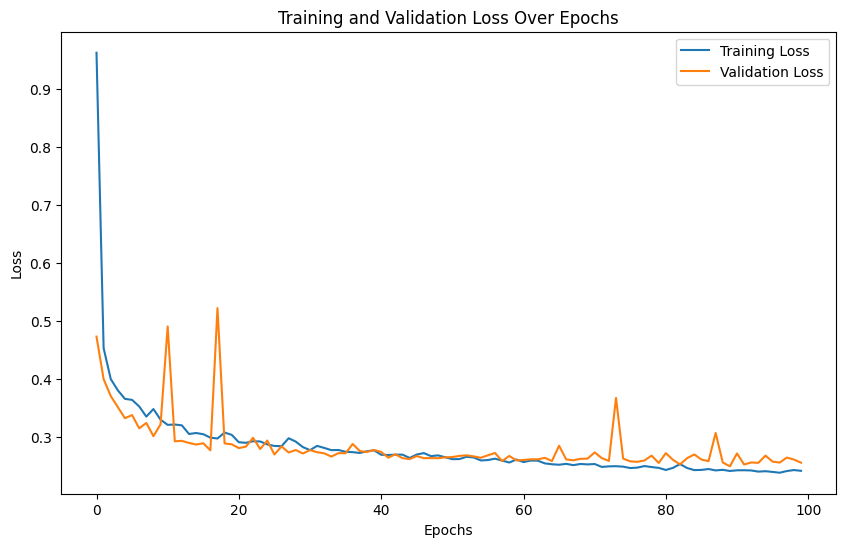

In [264]:
plt.figure(figsize=(10, 6))
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')  
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [265]:
x_test_normalized = scaler.transform(x_test)
y_pred = final_model.predict(x_test_normalized)
test_loss = mean_squared_error(y_test, y_pred)
print(f"Final Test Error (MSE): {test_loss}")

162/162 [==============================] - 0s 1ms/step
Final Test Error (MSE): 0.269711152040648


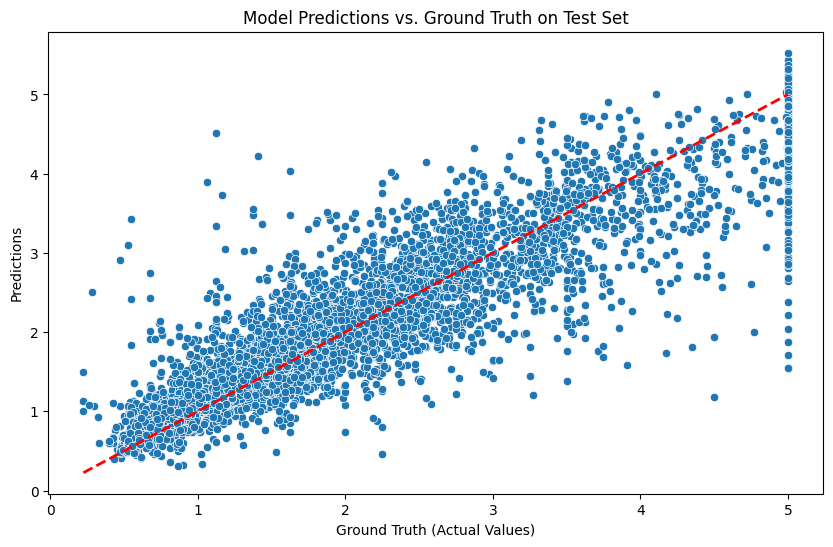

In [266]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test.flatten(), y=y_pred.flatten())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title('Model Predictions vs. Ground Truth on Test Set')
plt.xlabel('Ground Truth (Actual Values)')
plt.ylabel('Predictions')
plt.show()


Until now out final test error, measured by Mean Squared Error (MSE), is 0.2697, which indicates the average squared difference between the predicted median house values and the actual values in the test set. We know a lower MSE suggests better model performance, and in this case, our obtained value is reasonable, considering the complexity of predicting housing prices.

Our training process involved 100 epochs, and the model demonstrated a consistent decrease in both training and validation errors throughout the epochs. The training and validation Mean Absolute Error (MAE) values gradually decreased, that means our model learned to make predictions with higher precision.


# e)

In [267]:

y_train[y_train < 2], y_test[y_test < 2] = 0, 0
y_train[y_train >= 2], y_test[y_test >= 2] = 1, 1

binary_classification_model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_shape=(x_train_normalized.shape[1],)),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid')  # One neuron for binary classification
])

binary_classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


y_train = np.squeeze(y_train)

binary_classification_model.fit(
    x_train_normalized, y_train,
    batch_size=batch_size,
    epochs=final_epochs,
    verbose=2
)


x_test_normalized = scaler.transform(x_test)
y_pred_prob = binary_classification_model.predict(x_test_normalized)
y_pred_binary = (y_pred_prob[:, 0] > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy}")



Epoch 1/100
387/387 - 1s - loss: 0.4379 - accuracy: 0.8065 - 1s/epoch - 4ms/step
Epoch 2/100
387/387 - 1s - loss: 0.3614 - accuracy: 0.8420 - 531ms/epoch - 1ms/step
Epoch 3/100
387/387 - 1s - loss: 0.3449 - accuracy: 0.8498 - 616ms/epoch - 2ms/step
Epoch 4/100
387/387 - 0s - loss: 0.3319 - accuracy: 0.8548 - 465ms/epoch - 1ms/step
Epoch 5/100
387/387 - 1s - loss: 0.3233 - accuracy: 0.8572 - 509ms/epoch - 1ms/step
Epoch 6/100
387/387 - 0s - loss: 0.3188 - accuracy: 0.8604 - 470ms/epoch - 1ms/step
Epoch 7/100
387/387 - 1s - loss: 0.3154 - accuracy: 0.8610 - 569ms/epoch - 1ms/step
Epoch 8/100
387/387 - 1s - loss: 0.3114 - accuracy: 0.8650 - 590ms/epoch - 2ms/step
Epoch 9/100
387/387 - 1s - loss: 0.3088 - accuracy: 0.8659 - 556ms/epoch - 1ms/step
Epoch 10/100
387/387 - 1s - loss: 0.3094 - accuracy: 0.8640 - 647ms/epoch - 2ms/step
Epoch 11/100
387/387 - 1s - loss: 0.3053 - accuracy: 0.8639 - 607ms/epoch - 2ms/step
Epoch 12/100
387/387 - 1s - loss: 0.3038 - accuracy: 0.8651 - 562ms/epoch - 1

In [272]:
y_pred_binary = (binary_classification_model.predict(x_test_normalized) > 0.5).astype("int32")

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


162/162 [==============================] - 0s 1ms/step
Confusion Matrix:
[[2686  274]
 [ 358 1842]]
Accuracy: 0.8775193798449612
Precision: 0.8705103969754253
Recall: 0.8372727272727273
F1 Score: 0.8535681186283596


Accuracy: Our model achieved an accuracy of approximately 87.75%, which indicates that the model is making correct predictions for a large portion of the test set.

Confusion Matrix: From the confusion matrix, we see the model has 2686 true negatives (TN), 274 false positives (FP), 358 false negatives (FN), and 1842 true positives (TP). The high number of true positives and true negatives indicates that the model is effective in both identifying instances where the median house value is below $200,000 and where it is above $200,000.

Training Efficiency: Notably, the model attained a significant level of accuracy a small number of epochs (100), highlighting its efficiency in learning from the dataset. 